In [1]:
!pip install yfinance
!pip install sec-cik-mapper
!pip install pybacktestchain

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from src.pybacktestchain_EV.data_module import DataModule, EnhancedInformation, preprocess_data, get_stocks_data
from src.pybacktestchain_EV.strategies import (
    equal_weight_strategy,
    min_variance_strategy,
    max_sharpe_ratio_strategy,
    risk_parity_strategy,
)
from src.pybacktestchain_EV.broker import Broker
import numpy as np

/Users/enzo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
# Define parameters
initial_cash = 100000
tickers_list = ["AAPL", "MSFT", "GOOGL", "BZ=F"]
start_date = (datetime.today() - timedelta(days=365)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')
strategy = "Minimum Variance"  # Example strategy

In [5]:
# Fetch data
print("Fetching data for tickers...")
data = get_stocks_data(tickers_list, start_date, end_date)

print("Fetched Data Preview:")
print(data.head())

Fetching data for tickers...
Fetched Data Preview:
                       Date        Open        High         Low       Close  \
0 2024-01-11 00:00:00-05:00  186.539993  187.050003  183.619995  185.589996   
1 2024-01-12 00:00:00-05:00  186.059998  186.740005  185.190002  185.919998   
2 2024-01-16 00:00:00-05:00  182.160004  184.259995  180.929993  183.630005   
3 2024-01-17 00:00:00-05:00  181.270004  182.929993  180.300003  182.679993   
4 2024-01-18 00:00:00-05:00  186.089996  189.139999  185.830002  188.630005   

    Adj Close    Volume ticker  
0  184.685211  49128400   AAPL  
1  185.013611  40444700   AAPL  
2  182.734787  65603000   AAPL  
3  181.789398  47317400   AAPL  
4  187.710419  78005800   AAPL  


In [6]:
# Preprocess the data
try:
    processed_data = preprocess_data(data)
    print("Processed Data for Strategies:")
    print(processed_data.head())
except Exception as e:
    raise ValueError(f"Error in preprocessing data: {e}")

Processed Data for Strategies:
ticker            AAPL       BZ=F       GOOGL        MSFT
Date                                                     
2024-01-11  184.685211  77.410004  141.566818  381.775116
2024-01-12  185.013611  78.290001  142.134735  385.586639
2024-01-16  182.734787  78.290001  141.975327  387.373260
2024-01-17  181.789398  77.879997  140.959030  386.579224
2024-01-18  187.710419  79.099998  142.961746  390.946503


In [7]:
# Initialize DataModule and Enhanced Information
data_module = DataModule(data)
enhanced_info = EnhancedInformation(data_module=data_module)

# Initialize Broker
broker = Broker(cash=initial_cash, verbose=True)

In [8]:
# Simulate backtest
portfolio_value = []
transaction_log = []

for date in processed_data.index:
    prices = processed_data.loc[date]

    # Skip if prices have NaN
    if prices.isnull().any():
        print(f"Skipping date {date} due to missing data.")
        continue

    # Compute information set
    try:
        information_set = enhanced_info.compute_information(date)
        covariance_matrix = information_set['covariance_matrix']
        expected_return = information_set['expected_return']
    except ValueError as e:
        print(f"Data issue on {date}: {e}")
        continue

    # Strategy selection
    try:
        if strategy == "Equal Weight":
            portfolio = equal_weight_strategy(prices)
        elif strategy == "Minimum Variance":
            portfolio = min_variance_strategy(prices, covariance_matrix)
        elif strategy == "Maximum Sharpe Ratio":
            portfolio = max_sharpe_ratio_strategy(expected_return, covariance_matrix)
        elif strategy == "Risk-Parity":
            portfolio = risk_parity_strategy(prices, covariance_matrix)
    except ValueError as e:
        print(f"Strategy error on {date}: {e}")
        continue

    # Execute portfolio and handle errors
    try:
        broker.execute_portfolio(portfolio, prices, date)
        portfolio_value.append({"Date": date, "Portfolio Value": broker.get_portfolio_value(prices)})
        transaction_log.append(broker.get_transaction_log())
    except ValueError as e:
        print(f"Execution error on {date}: {e}")
        continue


/Users/enzo/Documents/Python/python_project/python_project_ev/src/pybacktestchain_EV/data_module.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['return'] = data.groupby(self.company_column)[self.adj_close_column].pct_change()
/Users/enzo/anaconda3/lib/python3.11/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/enzo/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/enzo/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/enzo/Doc

/Users/enzo/Documents/Python/python_project/python_project_ev/src/pybacktestchain_EV/data_module.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['return'] = data.groupby(self.company_column)[self.adj_close_column].pct_change()
INFO:root:Buying as many shares of BZ=F as possible with available cash.
/Users/enzo/Documents/Python/python_project/python_project_ev/src/pybacktestchain_EV/data_module.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['return'] = data.groupby(self.company_column)[s

Strategy error on 2024-01-11 00:00:00: shapes (0,0) and (4,) not aligned: 0 (dim 1) != 4 (dim 0)


INFO:root:Buying as many shares of AAPL as possible with available cash.
INFO:root:Buying as many shares of BZ=F as possible with available cash.
/Users/enzo/Documents/Python/python_project/python_project_ev/src/pybacktestchain_EV/data_module.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['return'] = data.groupby(self.company_column)[self.adj_close_column].pct_change()
INFO:root:Buying as many shares of AAPL as possible with available cash.
INFO:root:Buying as many shares of BZ=F as possible with available cash.
/Users/enzo/Documents/Python/python_project/python_project_ev/src/pybacktestchain_EV/data_module.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [9]:
# Convert portfolio value list to a DataFrame for analysis
portfolio_value_df = pd.DataFrame(portfolio_value).set_index("Date")

print("Transaction Log:")
if transaction_log:
    flat_transaction_log = pd.concat(transaction_log, ignore_index=True)
    print(flat_transaction_log)

print("Portfolio Value Over Time:")
print(portfolio_value_df)

Transaction Log:
            Date Action Ticker Quantity       Price          Cash
0     2024-01-16    BUY   AAPL      385  182.734787  29647.107010
1     2024-01-16    BUY   BZ=F       22   78.290001  27924.726990
2     2024-01-16    BUY  GOOGL      196  141.975327     97.562988
3     2024-01-16    BUY   AAPL      385  182.734787  29647.107010
4     2024-01-16    BUY   BZ=F       22   78.290001  27924.726990
...          ...    ...    ...      ...         ...           ...
61163 2025-01-06    BUY   BZ=F        0   76.300003     42.154709
61164 2025-01-07    BUY   AAPL        0  242.210007     42.154709
61165 2025-01-07    BUY   BZ=F        0   77.050003     42.154709
61166 2025-01-08    BUY   AAPL        0  242.699997     42.154709
61167 2025-01-08    BUY   BZ=F        0   76.160004     42.154709

[61168 rows x 6 columns]
Portfolio Value Over Time:
            Portfolio Value
Date                       
2024-01-12    100000.000000
2024-01-16    100000.000000
2024-01-17     99427.81114

/var/folders/qb/bs6whtv57ml99_6p1451xw800000gn/T/ipykernel_63026/4179882920.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flat_transaction_log = pd.concat(transaction_log, ignore_index=True)


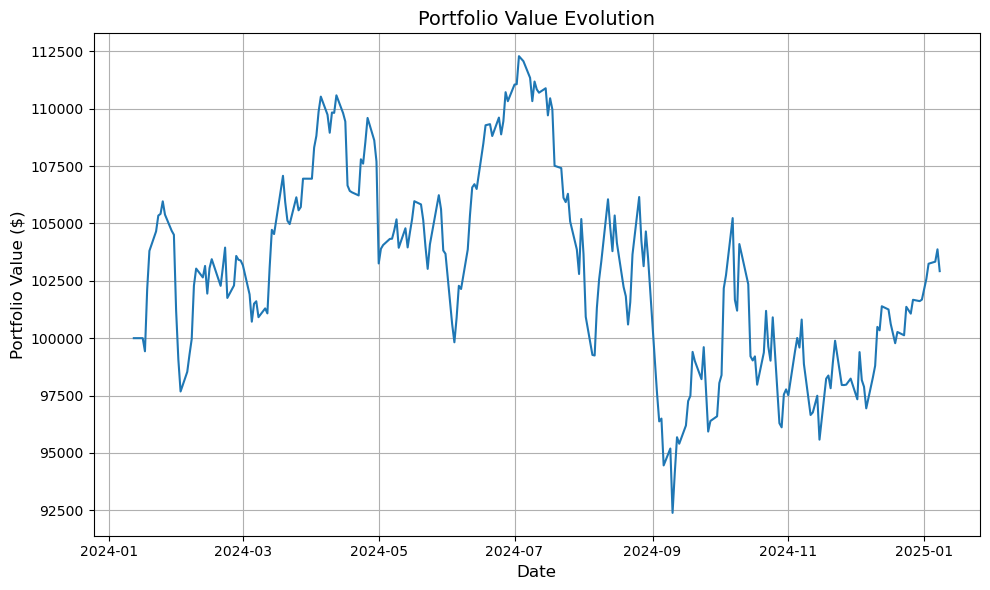

In [10]:
# Plot portfolio value evolution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value_df.index, portfolio_value_df["Portfolio Value"])
plt.title("Portfolio Value Evolution", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value ($)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


Portfolio Value Summary Statistics:
count       248.000000
mean     125171.541871
std       16780.460833
min       99252.638550
25%      109292.538574
50%      125868.127724
75%      134078.469959
max      165235.776001
Name: Portfolio Value, dtype: float64


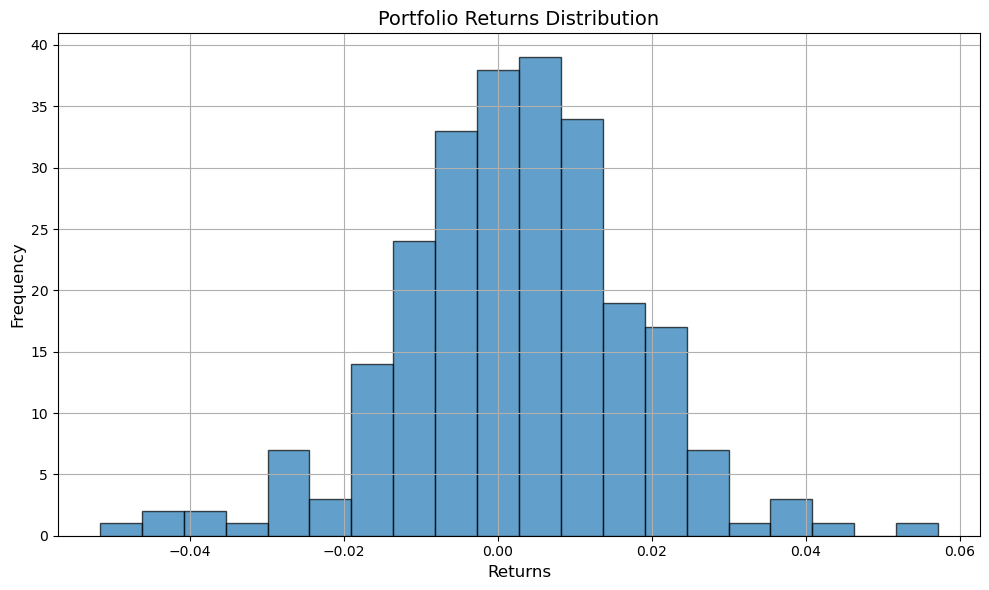


Portfolio Return Summary Statistics:
count    247.000000
mean       0.002027
std        0.015122
min       -0.051653
25%       -0.006310
50%        0.002649
75%        0.010939
max        0.057187
Name: Returns, dtype: float64


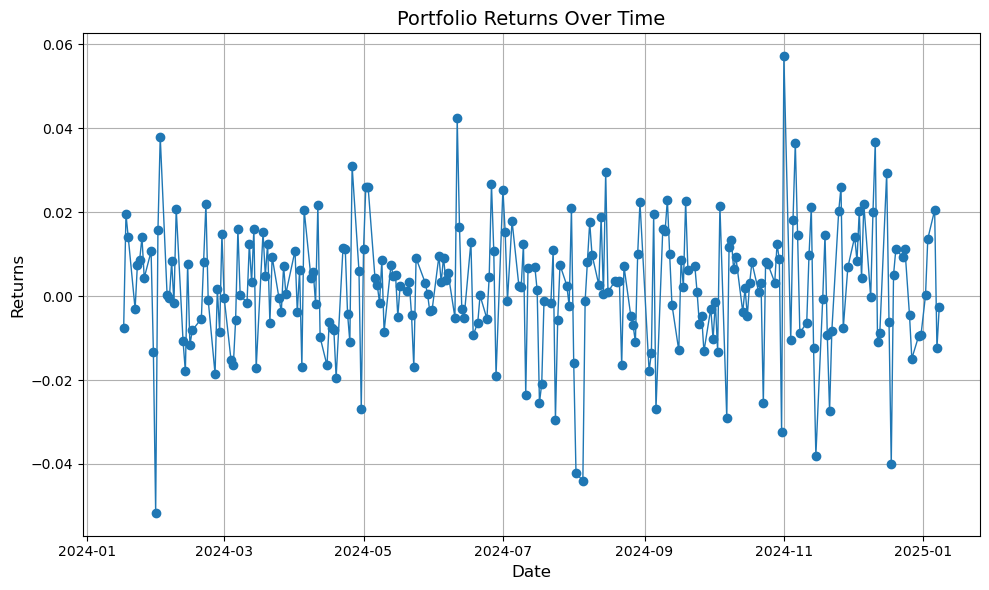

In [57]:
# Display summary statistics
summary_stats = portfolio_value_df["Portfolio Value"].describe()
print("\nPortfolio Value Summary Statistics:")
print(summary_stats)

# Plot histogram of portfolio returns distribution
portfolio_value_df["Returns"] = portfolio_value_df["Portfolio Value"].pct_change()
plt.figure(figsize=(10, 6))
plt.hist(portfolio_value_df["Returns"].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title("Portfolio Returns Distribution", fontsize=14)
plt.xlabel("Returns", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate portfolio returns and display return statistics
portfolio_value_df["Returns"] = portfolio_value_df["Portfolio Value"].pct_change()
return_stats = portfolio_value_df["Returns"].describe()
print("\nPortfolio Return Summary Statistics:")
print(return_stats)

# Plot portfolio returns over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value_df.index, portfolio_value_df["Returns"], marker='o', linestyle='-', linewidth=1)
plt.title("Portfolio Returns Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()